In [28]:
!pip install pandas matplotlib seaborn scikit-learn

In [67]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# **Assignment 3 - Dataset 2: Classification**

Group: #45

Isaac Lafond - 300191954

**Introduction:**

This notebook overview steps for a predictive analysis of classifying internet traffic as DDOS attacks based on the dataset detailed below. The steps required in achieving the predictive analysis are broken down in sections with text and code block describing the step in question. Executing this notebook will show the results of the code blocks which implement the steps of the predictive analysis.

**Dataset Description:**

This dataset by Oktay Ordekci, contains features to help predict if internet traffic is DDOS traffic. It contains several attributes such as highest layer of communication, transport layer type, source IP, destination IP, source port and destination port, packet length, packet/time and target which indicates whether or not the row represent DDOS traffic or not.

## **Classification Empirical Study**

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/IsaacLafond/CSI-4142---Fundamentals-of-Data-Science/main/Assignment%203/datasets/DDoS_dataset.csv")

### **a) Cleaning the data**

Here we apply checks for the presence of errors that would require cleaning/imputation.

True = all values pass the check

False = not all values pass the check

\* unless indicated diffrently in the results output

In [6]:
# 1 - Data type check

# iterate over each column in the dataframe df and ensure that each value in the column is of the correct data type
for column in df.columns:
  column_type = df[column].dtype
  print(f"{column}: {df[column].apply(lambda x: type(x) == column_type).all()} ({column_type})")

Highest Layer: False (object)
Transport Layer: False (object)
Source IP: True (int64)
Dest IP: False (object)
Source Port: True (int64)
Dest Port: True (int64)
Packet Length: True (int64)
Packets/Time: True (float64)
target: True (int64)


We see that each column with the object type fails our check. In fact these columns are string format and are better subject to further checks to better define necessary cleaning etc. (see format check, length check)

In [7]:
# 2 - Range check

# range columns
range_columns = ['Source IP', 'Dest IP', 'Source Port', 'Dest Port', 'target']

# parameters = column name: expected range (IP range 255, port 65535)
params = {
    'Source IP': range(0, 256),
    'Dest IP': range(0, 256),
    'Source Port': range(0, 65536),
    'Dest Port': range(0, 65536),
    'target': range(0, 2)
}

# iterate over each column and very that each value in the column is withing the given range in params
for column in range_columns:
  if df[column].dtype == 'object':
    # split the string by "." convert each item to int and check if in params range make an error false
    try:
      print(f"{column}: {df[column].apply(lambda x: all(int(item) in params[column] for item in x.split('.'))).all()}")
    except:
      print(f"{column}: False")
  else:
    print(f"{column}: {df[column].apply(lambda x: x in params[column]).all()}")

Source IP: True
Dest IP: False
Source Port: True
Dest Port: True
target: True


Dest IP again failed the range check where we assume that the address is an IPv4 address of ints between 0-255 split by ".". See the following format check to see why this is not the case.

In [8]:
# 3 - Format check
# allow any regex
any_regex = '.*'

# IPv4 regex
ipv4_regex = r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$'

# regex for integer
integer_regex = '^\d+$'
# regex for any floating point number
float_regex = '^\d+\.\d+$'
# regex for integer that is binary that is can only be 0 or 1
binary_regex = '^(0|1)$'

# parameters = column name: expected pattern
params = {
    'Highest Layer': any_regex,
    'Transport Layer': any_regex,
    'Source IP': binary_regex,
    'Dest IP': ipv4_regex,
    'Source Port': integer_regex,
    'Dest Port': integer_regex,
    'Packet Length': integer_regex,
    'Packets/Time': float_regex,
    'target': binary_regex
}

# iterate over each column in the dataframe and ensure each value matches the corresponding regex in param
for column in df.columns:
  # check if each value in the column matches the regex in params
  print(f"{column}: {df[column].astype(str).str.match(params[column]).all()}")

# Dest IP fails see values that fails
df[~df['Dest IP'].astype(str).str.match(params['Dest IP'])]['Dest IP'].value_counts()

Highest Layer: True
Transport Layer: True
Source IP: True
Dest IP: False
Source Port: True
Dest Port: True
Packet Length: True
Packets/Time: True
target: True


,count
Dest IP,
ff02::1:2,5193
ff02::1:3,72


Again we notice that Dest IP failed the format check. It appears the column not only contains IPv4 addresses but also condensed IPv6 addresses. In this case is seems that theses are only a handful of addresses and may not require cleaning.

In [9]:
# 4 - Consistency check

"""
In this dataset, based on the description, none of the columns are logically linked.
Therefore a consistency check is not needed.
"""
pass

In [10]:
# 5 - Uniqueness check

"""
This dataset doesn't contain any unique identifiers.
Although IP addresses are unique identifier, repitition is bound to be the case
as request may require multiple packets with the same IP address.
Therefore a uniqueness check is useful.
We observe the different IP address value counts below as an
overview of these values and a testament to this repetition.
"""
# pass
df['Dest IP'].value_counts()

,count
Dest IP,
192.168.1.1,798758
192.168.1.3,26568
255.255.255.255,8366
172.16.7.100,5574
ff02::1:2,5193
192.168.1.255,1564
169.254.255.255,1563
172.16.255.255,1122
192.168.1.11,1034


In [11]:
# 6 - Presence check

# iterate over each column and verify that all values arent empty
for column in df.columns:
  print(f"{column}: {df[column].notnull().any()}")

Highest Layer: True
Transport Layer: True
Source IP: True
Dest IP: True
Source Port: True
Dest Port: True
Packet Length: True
Packets/Time: True
target: True


In [12]:
# 7 - Length check
# define a length range class to verify if length is in expected range
class LengthRange:
  def __init__(self, min=0, max=float('inf')):
    self.min = min
    self.max = max
  def __contains__(self, x):
    return self.min <= len(x) <= self.max
any_length = LengthRange()

# parameters = column name: expected value length
params = {
    'Highest Layer': any_length,
    'Transport Layer': any_length,
    'Source IP': LengthRange(0, 15), # max length: 255.255.255.255 = 15 (may require future improvement for IPv6 addresses althought not currently necessary)
    'Dest IP': LengthRange(0, 15),
    'Source Port': LengthRange(0, 65535),
    'Dest Port': LengthRange(0, 65535),
    'Packet Length': any_length,
    'Packets/Time': any_length,
    'target': LengthRange(0, 1)
}

# iterate over each column and very that each value in the column is withing the given length range in params
for column in df.columns:
  print(f"{column}: {df[column].astype(str).apply(lambda x: x in params[column]).all()}")

Highest Layer: True
Transport Layer: True
Source IP: True
Dest IP: True
Source Port: True
Dest Port: True
Packet Length: True
Packets/Time: True
target: True


In [13]:
# 8 - Look-up check
# this check verifies that all the values are in the allowed set of values for that column
# for this test the only columns with a defined list of acceptable values is Has_Garden and Has_Pool (and IDs from 1-500)
# define any list that always contains the value you verify
class AnyList:
  def __contains__(self, x):
    return True
any_list = AnyList()

# parameters = column name: list of accepted values
params = {
    'Highest Layer': ['ARP', 'BOOTP', 'BROWSER', 'DATA', 'DHCPV6', 'LLMNR', 'NBNS', 'QUIC', 'SSDP', 'TCP'],
    'Transport Layer': ['TCP', 'UDP'],
    'Source IP': any_list,
    'Dest IP': any_list,
    'Source Port': range(0, 65536),
    'Dest Port': range(0, 65536),
    'Packet Length': any_list,
    'Packets/Time': any_list,
    'target': [0, 1]
}

# iterate over each column and verify each of its values are in the list of acceptable values
for column in df.columns:
  print(f"{column}: {df[column].apply(lambda x: x in params[column]).all()}")

Highest Layer: True
Transport Layer: True
Source IP: True
Dest IP: True
Source Port: True
Dest Port: True
Packet Length: True
Packets/Time: True
target: True


In [14]:
# 9 - Exact duplicate check

# check for any exact duplicates in the dataset
print(f"Presence of exact duplicates: {df.duplicated().any()}")

# get length of the duplicates
print(f"Number of exact duplicates: {len(df[df.duplicated()])}")

# duplicate pourcentage
formatted_percentage = "{:.2f}".format(len(df[df.duplicated()]) / len(df) * 100)
print(f"Duplicate percentage: {formatted_percentage}%")

df_cleaned = df.drop_duplicates()
len(df_cleaned)

Presence of exact duplicates: True
Number of exact duplicates: 766840
Duplicate percentage: 89.94%


85745

In [1]:
# 10 - Near duplicate check

"""
Based on the fact that ~89% of the data points are near duplicates,
we can assume that all if not most of the data points are near duplicates.
"""
pass

### **b) Categorical feature encoding**

In [51]:
# One hot encode all categorical data
df_encoded = pd.get_dummies(df, drop_first=True) # [1]
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852585 entries, 0 to 852584
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Source IP                852585 non-null  int64  
 1   Source Port              852585 non-null  int64  
 2   Dest Port                852585 non-null  int64  
 3   Packet Length            852585 non-null  int64  
 4   Packets/Time             852585 non-null  float64
 5   target                   852585 non-null  int64  
 6   Highest Layer_BOOTP      852585 non-null  bool   
 7   Highest Layer_BROWSER    852585 non-null  bool   
 8   Highest Layer_DATA       852585 non-null  bool   
 9   Highest Layer_DHCPV6     852585 non-null  bool   
 10  Highest Layer_LLMNR      852585 non-null  bool   
 11  Highest Layer_NBNS       852585 non-null  bool   
 12  Highest Layer_QUIC       852585 non-null  bool   
 13  Highest Layer_SSDP       852585 non-null  bool   
 14  High

### **c) EDA and Outlier detection**

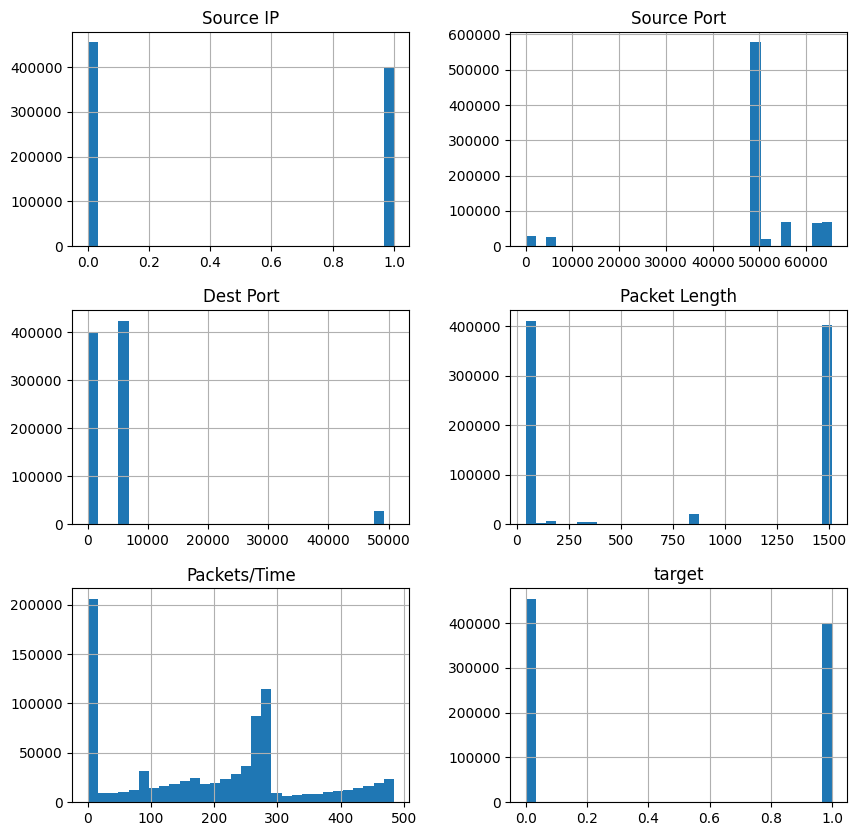

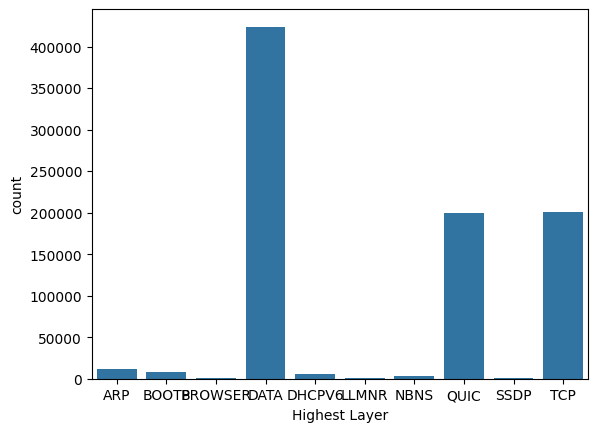

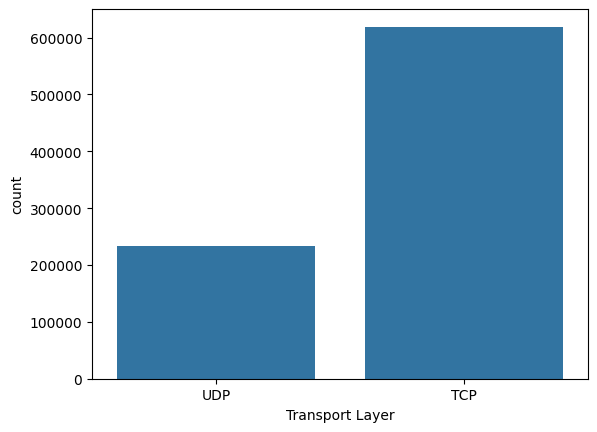

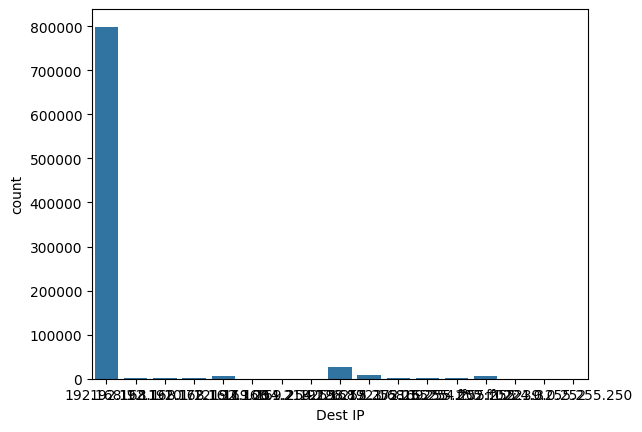

In [31]:
# Create histogram plots for each dataset feature
df.hist(bins=30, figsize=(10, 10))
plt.show()
# highest layer countplot
sns.countplot(x='Highest Layer', data=df)
plt.show()
# transport layer countplot
sns.countplot(x='Transport Layer', data=df)
plt.show()
# destination ip countplot
sns.countplot(x='Dest IP', data=df)
plt.show()

In [59]:
# LOC implementation
# select the subset of rows to take into account
LOC_subset = ['Packets/Time', 'Packet Length']
# create a copy of the dataframe containing only the selected columns
df_loc = df[LOC_subset].copy()
df_loc.drop_duplicates(inplace=True)

# fit and predict LOF
def LOF(df, n_neighbors=20, contamination=0.05): # 20 neighbours and 5% contamination
  lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
  df['LOF_Outliers'] = lof.fit_predict(df)
  return df['LOF_Outliers'].map({1: False, -1: True})

# Print the outlier counts
LOF(df_loc).value_counts()

,count
LOF_Outliers,
False,10978
True,578


### **d) Predictive analysis: Decision Trees**

In [93]:
# Implement a basic Linear Regression base model [2]
# temporary copy of the dataframe
df_temp = df_encoded.copy()
# clean the duplicates
df_temp.drop_duplicates(inplace=True)
df_temp.drop('Source IP', axis=1, inplace=True) # drop column with 1.0 correlation with target (df_temp.corr()['target'].sort_values(ascending=False))
# create the axis
X = df_temp.drop('target', axis=1)
y = df_temp['target']

# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=42)

# Init model
baseline_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    class_weight='balanced',
    random_state=42)
baseline_scores = cross_val_score(baseline_model, X_train, y_train, cv=4, scoring='accuracy')

# print the computed scores
print("Cross-validation accuracy Score:", baseline_scores.mean())

Cross-validation accuracy Score: 0.9993002507434836


### **e) Feature Engineering**

In [81]:
# Create additional features

# define if port is well known range
def is_well_known_port(port):
  return port <= 1023
# define if port is in registered range
def is_registered_port(port):
  return 1024 <= port <= 49151
# define if port is in dynamic range
def is_dynamic_port(port):
  return 49152 <= port <= 65535

def feature_engineering(df):
  # is well known
  df['Is_Well_Known_Port'] = df['Dest Port'].apply(is_well_known_port)
  # is registered
  df['Is_Registered_Port'] = df['Dest Port'].apply(is_registered_port)
  # is dynamic
  df['Is_Dynamic_Port'] = df['Dest Port'].apply(is_dynamic_port)
  # time per size ratio feature
  df['Time_Per_Size'] = df['Packets/Time'] / df['Packet Length']
  return df

### **f) Empirical study**

In [90]:
# Empirical study

# 4-fold cross validation evaluation
def evaluate_model(model, X, y):
  scores = cross_val_score(model, X, y, cv=4, scoring='accuracy')
  return scores.mean()

# Prepare data for analysis
df_emp_study = df_encoded.copy()
# drop duplicates
df_emp_study.drop_duplicates(inplace=True)
# drop 100% correlated column
df_emp_study.drop('Source IP', axis=1, inplace=True)

# split the dataset (train, validate and test)
train_val, test = train_test_split(df_emp_study, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42) # 0.25 * 0.8 = 20%

# Extract variable
X_train = train.drop('target', axis=1)
y_train = train['target']
X_val = val.drop('target', axis=1)
y_val = val['target']
X_test = test.drop('target', axis=1)
y_test = test['target']

# define variable after LOF
outliers = LOF(X_train)
train_no_outliers = train[~outliers]
X_train_no_outliers = train_no_outliers.drop('target', axis=1)
y_train_no_outliers = train_no_outliers['target']

# define variable after feature engineering
X_train_eng = feature_engineering(X_train.copy())
X_val_eng = feature_engineering(X_val.copy())
X_test_eng = feature_engineering(X_test.copy())

# define variable after LOF and feature engineering
X_train_both = feature_engineering(X_train_no_outliers.copy())
X_val_both = feature_engineering(X_val)

# define model
model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    class_weight='balanced',
    random_state=42)

# outliers removed
lof_score = evaluate_model(model, X_train_no_outliers, y_train_no_outliers)
print("No Outliers Accuracy Score:", lof_score)
# feature engineering
eng_score = evaluate_model(model, X_train_eng, y_train)
print("Feature Engineering Accuracy Score:", eng_score)
# both outliers removed and feature engineering
both_score = evaluate_model(model, X_train_both, y_train_no_outliers)
print("Both Score:", both_score)

No Outliers Accuracy Score: 0.9998158538467585
Feature Engineering Accuracy Score: 0.9991253183401569
Both Score: 0.9998158538467585


In [92]:
# final test for best performing configuration
best_model = model.fit(X_train_both, y_train_no_outliers)
test_score = best_model.score(X_test_eng, y_test)
print("Best Model Accuracy Score on test data:", test_score)

Best Model Accuracy Score on test data: 0.9986588139250102


### **g) Result analysis**

Observing the results we see that all three configurations saw similar performance to the baseline model. However we notice a very slight performance decrease when implementing feature engineering (FE) which seems to indicate a poor choice of engineered features. However, when combined with LOF outlier removal the model sees a slight performance boost comared to both the baseline model and feature engineered model. We also notice that only LOF outlier removal has identical performance to the combination of LOF and FE which show the effect of outliers on the performance of the model.

##**Conclusion**

In conclusion, this assignment overviewed the steps necessary to conduct a predictive analysis. Each step from data cleaning, encoding, EDA and outliers management and feature engineering is crucial for achieving good results such as the >99% accuracy achieved in this experiement.

## **References**

Outside of the references listed below, most code found in this notebook is the result of AI code suggestions provided by default in GoogleColab based on the comments listes and fine tune with method descriptions and documentation of the methods to achieve the desired result.

[1] https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

[2] ChatGPT: Prompt = I'm stuck, the output is still 1.0. The full output shows:
```
Cross-validation accuracy Score: 1.0
Test Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1305
           1       1.00      1.00      1.00     15844

    accuracy                           1.00     17149
   macro avg       1.00      1.00      1.00     17149
weighted avg       1.00      1.00      1.00     17149
```
My code is the following:
```
# Implement a basic Linear Regression base model [4]
# temporary copy of the dataframe
df_temp = df_encoded.copy()
# clean the duplicates
df_temp.drop_duplicates(inplace=True)
# create the axis
X = df_temp.drop('target', axis=1)
y = df_temp['target']

# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42)

# Init model
baseline_model = DecisionTreeClassifier(criterion='gini', max_depth=5, class_weight='balanced', random_state=42)
baseline_scores = cross_val_score(baseline_model, X_train, y_train, cv=4, scoring='accuracy')

# fit model
baseline_model.fit(X_train, y_train)
# make predictions on test set
y_pred = baseline_model.predict(X_test)

# compute metrics
accuracy = accuracy_score(y_test, y_pred)

# print the computed scores
print("Cross-validation accuracy Score:", baseline_scores.mean())
print("Test Accuracy:", accuracy)
print(classification_report(y_test, y_pred))"
```